In [1]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
training_data = np.load(f'../fashion_train.npy')
test_data = np.load(f'../fashion_test.npy')

labels = training_data[:, -1]
training_data = training_data[:,:-1] / 255 # Normalise pixel values
training_data = np.c_[training_data, labels] # Add labels back

labels = test_data[:, -1]
test_data = test_data[:,:-1] / 255 # Normalise pixel values
test_data = np.c_[test_data, labels] # Add labels back

In [3]:
# Helper functions
def MSE(y_pred, y):
    return 2 * np.mean([(y_i - y_pred_i)**2 for y_i, y_pred_i in zip(y, y_pred)])

def MSE_derivative(y_pred, y):
    return [(y_i - y_pred_i) for y_i, y_pred_i in zip(y, y_pred)]

def CrossEntropy(y_pred, y):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y * np.log(y_pred), axis=1))

def CrossEntropy_derivative(y_pred, y):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y) / y.shape[0]

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def reLU(x):
    return np.maximum(0, x)

def reLU_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_reLU(x):
    return np.maximum(0.01 * x, x)

def leaky_reLU_derivative(x):
    return np.where(x > 0, 1, 0.01)

def ELU(x):
    return np.maximum(0.01 * (np.exp(x)-1), x)

def ELU_derivative(x):
    return np.where(x > 0, 1, 0.01* np.exp(x))

def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return probabilities

def xavier_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)

def he_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)


In [4]:
def forward_pass(data, weights, biases, num_hidden_layers, activation_function):
    inputs, outputs = [], []
    current_input = data

    z = np.dot(current_input, weights["input"]) + biases["input"]
    inputs.append(z)
    current_input = activation_function(z)
    outputs.append(current_input)

    for i in range(num_hidden_layers):
        z = np.dot(current_input, weights["hidden"][i]) + biases["hidden"][i]
        inputs.append(z)
        current_input = activation_function(z)
        outputs.append(current_input)

    z = np.dot(current_input, weights["output"]) + biases["output"]
    inputs.append(z)
    current_input = softmax(z)
    outputs.append(current_input)

    return inputs, outputs

def backward_pass(data, labels, weights, biases, inputs, outputs, activation_function_derivative, cost_derivative, learning_rate):
    # Calculate delta for output layer
    delta = cost_derivative(outputs[-1], labels) * activation_function_derivative(inputs[-1])
    
    # Gradients for output layer
    gradient_weights_output = np.dot(outputs[-2].T, delta)  # Last hidden layer's output
    gradient_biases_output = np.sum(delta, axis=0, keepdims=True)

    # Update output layer weights and biases
    weights["output"] -= learning_rate * gradient_weights_output
    biases["output"] -= learning_rate * gradient_biases_output

    num_hidden_layers = len(weights["hidden"])
    # Gradients for hidden layers
    for i in range(num_hidden_layers-1, -1, -1):
        if i == len(weights["hidden"])-1:
            delta = np.dot(delta, weights["output"].T) * activation_function_derivative(inputs[-2])
        else:
            delta = np.dot(delta, weights["hidden"][i+1].T) * activation_function_derivative(inputs[-2 +  i - num_hidden_layers])

        gradient_weights_hidden = np.dot(outputs[-2 +  i - num_hidden_layers].T, delta)
        gradient_biases_hidden = np.sum(delta, axis=0, keepdims=True)
        # Update hidden layer weights and biases
        weights["hidden"][i] -= learning_rate * gradient_weights_hidden
        biases["hidden"][i] -= learning_rate * gradient_biases_hidden

    delta = np.dot(delta, weights["hidden"][0].T) * activation_function_derivative(inputs[0])
    gradient_weights_input = np.dot(data.T, delta)
    gradient_biases_input = np.sum(delta, axis=0, keepdims=True)

    # Update input layer weights and biases
    weights["input"] -= learning_rate * gradient_weights_input
    biases["input"] -= learning_rate * gradient_biases_input

    return weights, biases

In [6]:
def feedforward(data, num_hidden_layers, learning_rate, epochs, activation_function):
    np.random.seed(42)

    if activation_function == 'sigmoid':
        initialization = xavier_initialization
        activation_function_ = sigmoid
        activation_function_derivative_ = sigmoid_derivative
        cost_function_ = MSE
        cost_derivative_ = MSE_derivative
    elif activation_function == 'relu':
        initialization = he_initialization
        activation_function_ = reLU
        activation_function_derivative_ = reLU_derivative
        cost_function_ = CrossEntropy
        cost_derivative_ = CrossEntropy_derivative
    elif activation_function == 'leaky_relu':
        initialization = he_initialization
        activation_function_ = leaky_reLU
        activation_function_derivative_ = leaky_reLU_derivative
        cost_function_ = CrossEntropy
        cost_derivative_ = CrossEntropy_derivative
    elif activation_function == 'ELU':
        initialization = he_initialization
        activation_function_ = ELU
        activation_function_derivative_ = ELU_derivative
        cost_function_ = CrossEntropy
        cost_derivative_ = CrossEntropy_derivative
    else:
        raise ValueError("Invalid activation function. Choose 'sigmoid', 'leaky_relu', 'ELU' or 'relu'.")
        
    # Weight initialization
    num_samples, num_features = data.shape[0], data.shape[1]-1
    input_layer_size = num_features
    hidden_layer_size = 16

    output_layer_size = len(np.unique(data[:,-1]))

    weights = {
        "input": initialization(input_layer_size, hidden_layer_size),
        "hidden": np.array([initialization(hidden_layer_size, hidden_layer_size) for _ in range(num_hidden_layers)]),
        "output": initialization(hidden_layer_size, output_layer_size)
    }
    biases = {
        "input": np.zeros((1, hidden_layer_size)),
        "hidden": [np.zeros((1, hidden_layer_size)) for _ in range(num_hidden_layers)],
        "output": np.zeros((1, output_layer_size))
    }

    # -------------------------------------------------------------------------------------------------------------

    labels = data[:, -1]
    data_no_labels = data[:, :-1]
    num_classes = len(np.unique(labels))
    classes = np.eye(num_classes)[labels.astype(int)]

    input, output = forward_pass(data_no_labels, weights, biases, num_hidden_layers,activation_function_)

    for epoch in range(epochs):
        weights, biases = backward_pass(data_no_labels, classes, weights, biases, input, output, activation_function_derivative_, cost_derivative_, learning_rate)

        input, output = forward_pass(data_no_labels, weights, biases, num_hidden_layers, activation_function_)

        if epoch % 10 == 0:
            cost = cost_function_(output[-1], classes)
            print(f"Epoch: {epoch}, Cost: {cost}")
    return weights, biases, num_hidden_layers, activation_function_

In [7]:
def predict(data, weights, biases, num_hidden_layers, activation_function):
    data_labels = data[:, -1].astype(int)
    data_no_labels = data[:, :-1]
    inputs, outputs = forward_pass(data_no_labels, weights, biases, num_hidden_layers, activation_function)
    pred = np.argmax(outputs[-1], axis=1).astype(int)
    accuracy = (np.sum(pred == data_labels) / len(data_labels)) * 100
    num_classes = len(np.unique(data_labels))
    confusion_matrix = np.zeros((num_classes, num_classes),dtype=int)
    for i in range(len(data_labels)):
        confusion_matrix[data_labels[i], pred[i]] += 1
    
    misclassification_rate = []
    for i in range(num_classes):
        total_row = np.sum(confusion_matrix[i,:])
        error_rate = confusion_matrix[i,i] / total_row
        misclassification_rate.append(error_rate)
    print(misclassification_rate)
    return accuracy, confusion_matrix

In [18]:
# currently 10k with 2 hidden layers and leaky relu takes 14-16 minutes (with my pc)
weights, biases, num_hidden_layers, activation_function_ = feedforward(training_data, 2, 0.01, 1000, 'relu')

Epoch: 0, Cost: 1.7869268404926895
Epoch: 10, Cost: 1.6312338444039276
Epoch: 20, Cost: 1.6123941365790984
Epoch: 30, Cost: 1.6058320008857812


KeyboardInterrupt: 

[0.353, 0.0, 0.956, 0.0, 0.003]


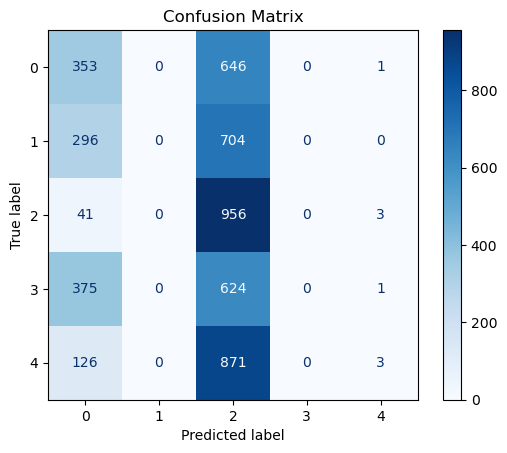

Accuracy: 26.24%


In [ ]:
accuracy, confusion_matrix = predict(test_data, weights, biases, num_hidden_layers, activation_function_)

#Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.arange(5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy:.2f}%")